In [1]:
import xarray as xr
import numpy as np
import os
import xesmf as xe
from compute_ETo import *

#### Surface resistance by inversion of Penman Monteith

#### $r_{s} = \frac{r_{a}}{\gamma}[\frac{\Delta R_{n} + \gamma \frac{900}{T+273} u_{2}(e_{s} - e_{a})}{\lambda ET} -\Delta - \gamma] $

By substituting $r_{a}$ with $\frac{208}{u_{2}}$, $r_{s}$ can be expressed as:  


#### $r_{s} = \frac{208}{u_{2} \gamma}[\frac{\Delta R_{n} + \gamma \frac{900}{T+273} u_{2}(e_{s} - e_{a})}{\lambda ET} -\Delta - \gamma] $


${\lambda ET}$ (mm) represent the latent heat flux and $R_{n}$ is in units of MJ/m2/day.

The inputs have also been preprocessed from the gridded_ETo notebook

### Read inputs

In [12]:
Rn = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Rn_ROI_10km.nc")
vpd = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\vpd_10km.nc") 
mswx_tmean = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\Tmean_KE_data.nc")
mswx_wind  = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\wind_KE_data.nc")
delta = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\delta_10km.nc")
gamma = xr.open_dataset(r"D:\VUB\_data\mswx_ETo_inputs\psychrometric_constant_500m.nc")
modis_LE = xr.open_dataset(r"D:\VUB\_data\nc_files\modis_LE_2000_2023.nc")

In [42]:
#convert wind speed to 2m
wind_2m = compute_2m_wind_speed(mswx_wind,10)

#select time period
mswx_wind = mswx_wind.sel(time=slice("2000-01-01",'2023-10-26'))
mswx_tmean = mswx_tmean.sel(time=slice("2000-01-01",'2023-10-26'))
modis_LE = modis_LE.sel(time=slice("2000-01-01",'2023-10-26'))

### Interpolate datasets to uniform grid

In [16]:
# Define the desired resolution
resolution = 0.027  # Degrees

# Create the target grid with the new resolution
lat_start = gamma.lat.min()
lat_end = gamma.lat.max()
lon_start = gamma.lon.min()
lon_end = gamma.lon.max()

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(lat_start, lat_end + 0.5*resolution, resolution), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(lon_start, lon_end + 0.5*resolution, resolution), {"units": "degrees_east"}),
    }
)

datasets = [Rn, vpd, mswx_tmean, wind_2m, delta, gamma,modis_LE]
dataset_names = ["Rn", "vpd", "mswx_tmean", "mswx_wind", "delta", "gamma","modis_LE"]

# Regrid all datasets to the new resolution
common_grid = {}
for ds, name in zip(datasets, dataset_names):
    regridder = xe.Regridder(ds, ds_out, "bilinear")
    ds_out = regridder(ds)
    common_grid[name] = ds_out

#### Compute surface conductance

In [28]:
k1 = 208/common_grid["mswx_wind"]['wind_speed'] * common_grid["gamma"]['psychrometric_constant']
k2 = common_grid["delta"]['air_temperature'] * common_grid["Rn"]['Rn']
k3 = 900/(common_grid['mswx_tmean']['air_temperature']+273) 
k4 = common_grid["mswx_wind"]['wind_speed'] * (common_grid["vpd"]['VPD'])

In [30]:
datasets = [k1, k2, k3, k4]
names = ["k1", "k2", "k3", "k4"]
ds_inputs = list()
for ds, ds_name in zip(datasets, names):
    ds.name = ds_name
    ds = ds.to_dataset()
    ds_inputs.append(ds)

ds = xr.merge(ds_inputs)

In [80]:
common_grid['modis_LE']= common_grid['modis_LE'].where(common_grid['modis_LE']<32700)

In [90]:
rs = ds['k1'] * (ds['k2'] + ds['k3'] * ds['k4'] - common_grid['delta']['air_temperature'] - common_grid['gamma']['psychrometric_constant'])

#Extract grouped values to match modis LE frequency

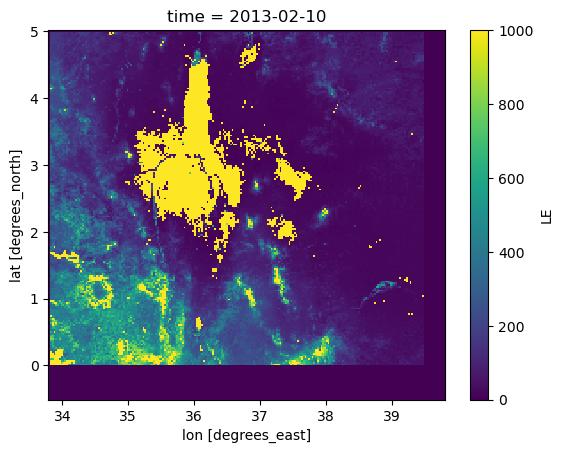

In [97]:
common_grid['modis_LE']['LE'][0].plot()